```
Copyright 2019 Augusto Cunha and Axelle Pochet

Permission is hereby granted, free of charge, to any person obtaining a copy of this code and 
associated documentation files, to deal in the code without restriction, 
including without limitation the rights to use, copy, modify, merge, publish, distribute, 
sublicense, and/or sell copies of the code, and to permit persons to whom the code is 
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or 
substantial portions of the code.

THE CODE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT 
NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND 
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, 
DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, 
OUT OF OR IN CONNECTION WITH THE CODE OR THE USE OR OTHER DEALINGS IN THE CODE.

__license__ = "MIT"
__author__ = "Augusto Cunha, Axelle Pochet"
__email__ = "acunha@tecgraf.puc-rio.br, axelle@tecgraf.puc-rio.br"
__credits__ = ["Augusto Cunha", "Axelle Pochet", "Helio Lopes", "Marcelo Gattass"]
```

# SFD-CNN-TL: Train final model and save

In [1]:
import os
import sys
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as im
os.environ['KERAS_BACKEND'] = 'tensorflow'
import classifier
import imageio
import keras.utils.vis_utils as graph # new keras version
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.filters import gaussian
from skimage import measure
from skimage import exposure
from sklearn.feature_extraction import image
from sklearn import svm
from sklearn.externals import joblib
from sklearn.utils import shuffle
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image, ImageDraw
from keras.models import Sequential, Model, model_from_json
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D # new keras version
from keras.utils import np_utils
from keras import regularizers
from keras.callbacks import EarlyStopping

np.random.seed(1337)

Using TensorFlow backend.


In [2]:
# Enable interactive plots
%matplotlib notebook

## Workflow
- Use our provided Syntectic dataset network weights
- Interpret one slice of the real data volume that will be classified
- Generate slice fault mask
- Train and save each analyzed method

## Define a seismic name

In [3]:
seismic_name = "gsb"

## Format csv file

In [4]:
# Gaussian smoothing with default std 1.5
# https://stackoverflow.com/a/45020378
def myGaussSmooth( data, std=1.5):
    return gaussian(data,sigma=std,truncate=2)

In [5]:
#Clipping 
def clip(data,min=-6000,max=6000):
    data[data>max] = max
    data[data<min] = min
    return data

In [6]:
# Normalizes values of a matrix between -1 and 1
def myNormalization(data):
    max_val = np.max(data)
    min_val = np.min(data)
    
    return  2 * (data[:,:] - min_val) / (max_val - min_val) - 1

<IPython.core.display.Javascript object>


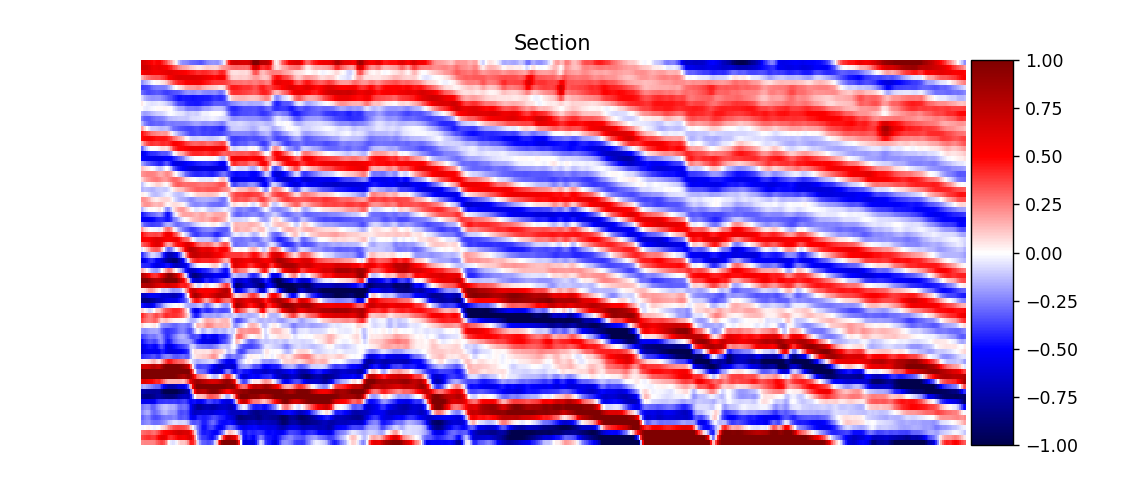

In [7]:
# Set configurations for format subvolume
data_file = 'data/gsb_crl_2800.csv'
min_inl = 1565 #1565
max_inl = 2531 #2531
step_inl = 2
min_crl = 2800 #2568
max_crl = 2800 #3568
step_crl = 2
min_z = 1000
max_z = 1300
step_z = 4

# Define sections type
types=['inline','crossline','z-slice','section_coords']
section_type = 'crossline'

output_dir = 'data/formatted/'+seismic_name+'/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir) 

# Read and format files
raw_data = np.genfromtxt(data_file, delimiter='\t')

if(section_type == "inline"):
    nb_crosslines = (max_crl - min_crl) / step_crl + 1
    
if(section_type == "crossline"):
    nb_crosslines = (max_inl - min_inl) / step_inl + 1
    
nb_sections = raw_data.shape[0]/nb_crosslines

for k in range(int(nb_sections)):
    # Output name
    if(section_type == "inline"):
        inl_nb = int(min_inl + k);
        name = 'inl'+str(inl_nb)+'_sc_formatted.csv'
    if(section_type == "crossline"):
        crl_nb = int(min_crl + k);
        name = 'crl'+str(crl_nb)+'_sc_formatted.csv'

    # Read
    section = raw_data[k*int(nb_crosslines) : (k+1)*int(nb_crosslines), : ]
    section = np.transpose(section)
    section = np.fliplr(section)
    
    # Smooth
    section = myGaussSmooth(section)

    # Clip
    section = clip(section)
    
    #perc = np.percentile(section, [1,99])
    #section = exposure.rescale_intensity(section, in_range=(perc[0], perc[1]), out_range=(0,255))

    # Normalize between -1 and 1 
    section = myNormalization(section)

    # Write
    #np.savetxt(output_dir + name, section, delimiter=" ")
    
    # Visualize
    plt.figure(figsize=(9,4))
    plt.title('Section')
    plt.axis('off')
    ax = plt.gca()
    im = plt.imshow(section, cmap="seismic", aspect='auto')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

## Create colormap

In [8]:
# get colormap
ncolors = 256
color_array = plt.get_cmap('gray')(range(ncolors))
# change alpha values
color_array[:,-1] = np.linspace(0.0,1.0,ncolors)
color_array[255] = [1., 0., 0., 0.5]

# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='faults',colors=color_array)

# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)

## Generate mask image from fault points file
Our faults was exported from opendTect as ordered point set, witch points pair is one fault

<IPython.core.display.Javascript object>


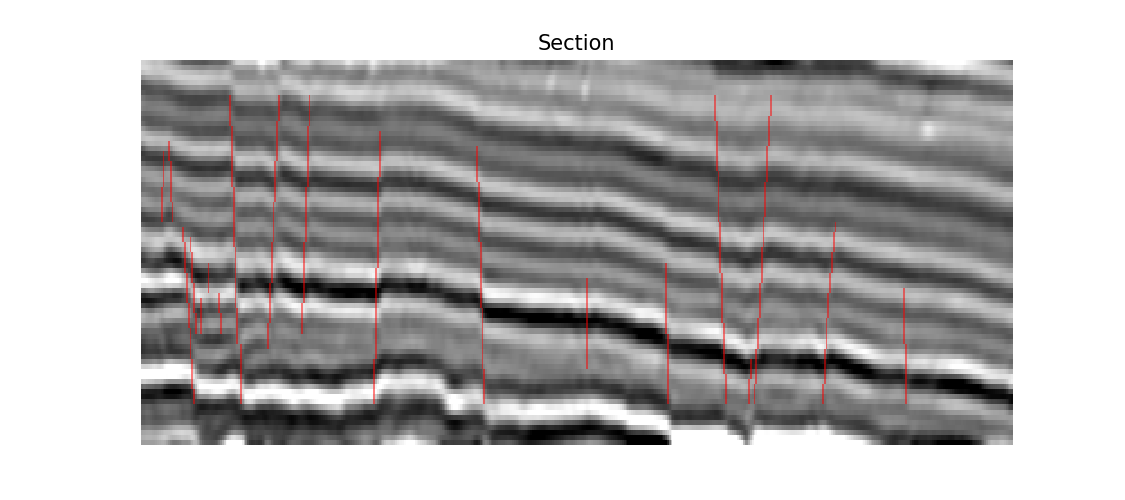

In [9]:
mask_file = 'data/gsb_crl_2800_mask.ascii'
mask_data = np.genfromtxt(mask_file, delimiter='\t')
lines_pair_points = []

for i in range(0,mask_data.shape[0]):
    lines_pair_points.append((mask_data[i,1]-min_inl)/step_inl)
    lines_pair_points.append(int((mask_data[i,3]-min_z)/step_z))

im = Image.new('L', (section.shape[1], section.shape[0]), 0)

draw = ImageDraw.Draw(im)
for i in range(0,len(lines_pair_points),4):
    draw.line((lines_pair_points[i],lines_pair_points[i+1],lines_pair_points[i+2],lines_pair_points[i+3]), fill=1, width=1)
del draw

mask_img = np.array(im)
mask_img = np.fliplr(mask_img)

 # Visualize
plt.figure(figsize=(9,4))
plt.title('Section')
plt.axis('off')
plt.imshow(section, cmap="gray", aspect='auto')
plt.imshow(mask_img, cmap="faults", aspect='auto')
plt.imsave('mask.png', mask_img, cmap="gray")


<IPython.core.display.Javascript object>


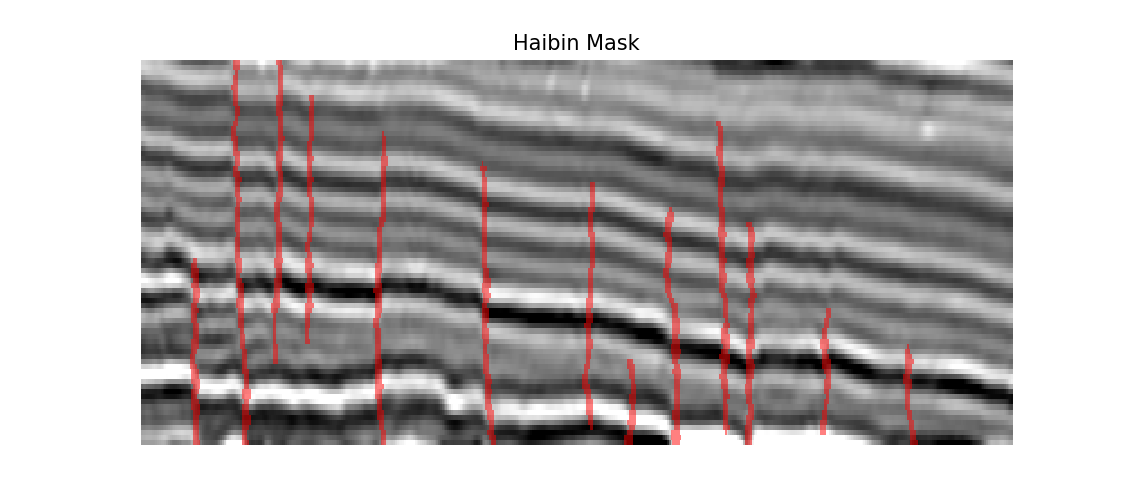

In [10]:
# Load Haibin mask
haibin_mask = cv2.imread("gsb_crl2800_haibin_mask.png")
haibin_mask = haibin_mask[:,:,1]
haibin_mask = haibin_mask/255

mask_img = haibin_mask

plt.figure(figsize=(9,4))
plt.title('Haibin Mask')
plt.axis('off')
plt.imshow(section, cmap="gray", aspect='auto')
plt.imshow(haibin_mask, cmap="faults", aspect='auto')
plt.imsave('mask_haibin.png', haibin_mask, cmap="gray")

<IPython.core.display.Javascript object>


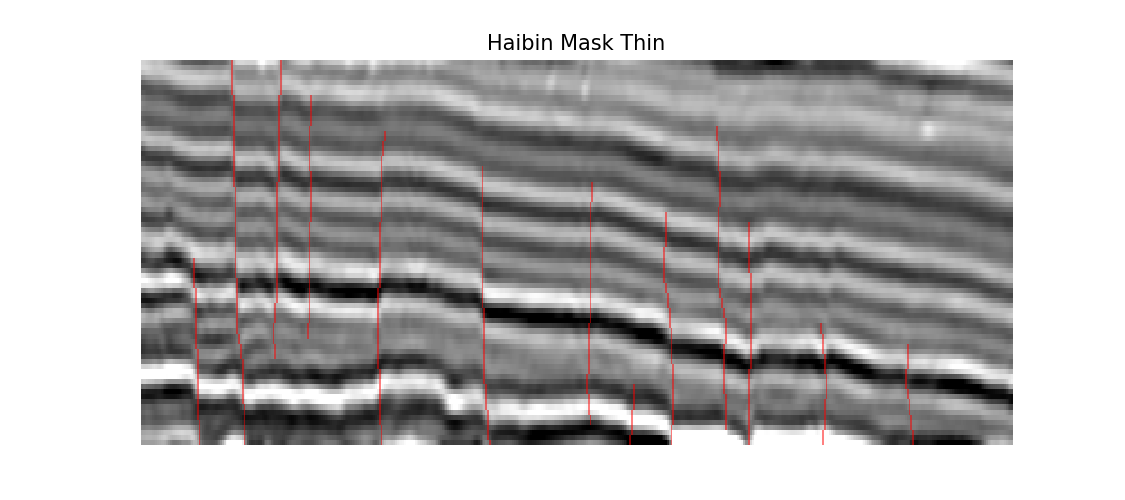

In [11]:
# Load thin Haibin mask
haibin_mask = cv2.imread("gsb_crl2800_haibin_thin_mask.png")
haibin_mask = haibin_mask[:,:,1]
haibin_mask = haibin_mask/255

mask_img = haibin_mask

plt.figure(figsize=(9,4))
plt.title('Haibin Mask Thin')
plt.axis('off')
plt.imshow(section, cmap="gray", aspect='auto')
plt.imshow(haibin_mask, cmap="faults", aspect='auto')
plt.imsave('mask_haibin_thin.png', haibin_mask, cmap="gray")

## Generate patches from real slice

In [ ]:
width = section.shape[1]
height = section.shape[0]
mask_size = 13

patches_fault = []
patches_non_fault = []

patches_img = image.extract_patches_2d(section, (mask_size, mask_size))
patches_mask = image.extract_patches_2d(mask_img, (mask_size, mask_size))

for i in range(0, len(patches_mask)):
    if (patches_mask[i] == 0).sum() == patches_mask[i].size:
        patch = patches_img[i]
        patch = cv2.resize(patch, dsize=(45, 45), interpolation=cv2.INTER_CUBIC)
        patch = np.clip(patch, -1., 1.)
        patches_non_fault.append(patch)
    elif patches_mask[i][int(mask_size/2),int(mask_size/2)]==1:
        patch = patches_img[i]
        patch = cv2.resize(patch, dsize=(45, 45), interpolation=cv2.INTER_CUBIC)
        patch = np.clip(patch, -1., 1.)
        patches_fault.append(patch)

## Train and save each analyzed method

In [ ]:
# pass input as numpy arrays
X = np.array(patches_fault + patches_non_fault)
X = X.reshape( X.shape[0], 45, 45, 1)
X = X.astype( 'float32' )

# sparsify labels
patches = np.concatenate([np.full(len(patches_fault),1),np.full(len(patches_non_fault),0)])
Y = np_utils.to_categorical(patches.tolist(), 2)

#Shuffle dataset
shuffle(X, Y, random_state=1337)

## FFT

In [ ]:
 def create_FFT(x_train, y_train, numberOfClasses=2):
    ################# load base model #################
    modelJsonPath = 'base_model/model.json'
    modelWeightsPath = 'base_model/model.h5'

    jsonFile = open(modelJsonPath, 'r')
    loadedModelJson = jsonFile.read()
    jsonFile.close()
    base_model = model_from_json(loadedModelJson)
    base_model.load_weights(modelWeightsPath)
        
    #### try just fine tuning base_model
    numberOfEpochs = 20
    batchSize = 30 

    ### Early stopping  
    #early_stop = EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=1, mode='auto')
    
    base_model.compile( loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'] )
    #base_model.fit(x_train, y_train, batch_size = batchSize, epochs = numberOfEpochs, verbose = 1, callbacks=[early_stop])
    base_model.fit(x_train, y_train, batch_size = batchSize, epochs = numberOfEpochs, verbose = 1)
        
    ################# save model #################
    model_json = base_model.to_json() # base_model
    with open("models/"+seismic_name+"FFT_haibin.json", "w") as json_file: json_file.write(model_json)
    # serialize weights to HDF5
    base_model.save_weights("models/"+seismic_name+"FFT_haibin.h5") # base_model

In [ ]:
create_FFT(X,Y)

## MLP

In [ ]:
def create_MLP(x, y, numberOfClasses=2, MLP1=100, MLP2=200, numberOfEpochs=20):
    ################# load base model #################
    modelJsonPath = 'base_model/model.json'
    modelWeightsPath = 'base_model/model.h5'

    jsonFile = open(modelJsonPath, 'r')
    loadedModelJson = jsonFile.read()
    jsonFile.close()
    base_model = model_from_json(loadedModelJson)
    base_model.load_weights(modelWeightsPath)

    ## vizualisation
    #base_model.summary()
    
    ################# freeze feature extraction layers #################
    for layer in base_model.layers[:7]:
        layer.trainable = False

    ## vizualisation
    #base_model.summary()
    
    my_model = base_model

    # remove last layers
    for i in range (8):
        my_model.layers.pop()
        my_model.outputs = [my_model.layers[-1].output]

    #my_model.summary()

    #### keras Sequential implementation
    model_final = my_model
    model_final.add(Flatten())
    model_final.add(Dense(MLP1)) # 100
    model_final.add(Activation('relu', name = 'act_1')) # set name, otherwise duplicate names appear
    model_final.add(Dropout(0.5)) #0.5 
    model_final.add(Dense(MLP2))
    model_final.add(Activation('relu', name = 'act_2'))
    model_final.add(Dense(numberOfClasses)) # camada de saida
    model_final.add(Activation('softmax', name = 'softmax')) # saida { prob classe1, prob classe2 }
    
    model_final.compile( loss='binary_crossentropy', optimizer= 'sgd', metrics=['accuracy'] )

    ################# train #################

    #### try just fine tuning base_model
    batchSize = 30
    ### Early stopping  
    #early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
    
    model_final.fit( x, y, batch_size = batchSize, epochs = numberOfEpochs, verbose = 1, validation_split=0.2 )
    
    ################# save model #################
    model_json = model_final.to_json() # base_model
    with open("models/"+seismic_name+"MLP_haibin.json", "w") as json_file: json_file.write(model_json)
    # serialize weights to HDF5
    model_final.save_weights("models/"+seismic_name+"MLP_haibin.h5") # base_model

In [ ]:
create_MLP(X,Y)

## SVM

In [ ]:
def create_SVM(data_x, data_y, numberOfClasses=2, c=10, K='rbf', save=False):
    ################# load base model #################
    #print( "Importing base model..." )
    modelJsonPath = 'base_model/model.json'
    modelWeightsPath = 'base_model/model.h5'

    jsonFile = open(modelJsonPath, 'r')
    loadedModelJson = jsonFile.read()
    jsonFile.close()
    base_model = model_from_json(loadedModelJson)
    base_model.load_weights(modelWeightsPath)

    ## vizualisation
    #base_model.summary()

    my_model = base_model 

    # remove last layers
    for i in range (7):
        my_model.layers.pop()
        my_model.outputs = [my_model.layers[-1].output]

    #my_model.summary()

    ################# freeze feature extraction layers #################
    for layer in my_model.layers[:7]:
        layer.trainable = False

    ## vizualisation
    #base_model.summary()
    ##
    
    ################# format data #################
    # sparsify labels
    numberOfClasses = 2
    y = np.argmax(data_y ,axis=1)
    
    ## extract features as new input
    x = my_model.predict(data_x)
    
    ################# define SVM ################# 
    classifier = svm.SVC(kernel = K, C = c, probability=True, random_state=1337)
    classifier.fit(x, y)
    
    joblib.dump(classifier, 'models/'+seismic_name+'SVM_haibin.pkl')

In [ ]:
create_SVM(X,Y)